# Modern Molecular Physcis exercises

yachmena@

Here is a set of exercises used for the course "Modern Molecular Physcis" at the University of Hamburg.

Richmol is a pretty general module that allows you to set up rotational, vibrational, and ro-vibrational Hamiltonians for a general molecule and solve the stationary or time-depenent Schrödinger equation.

In this course, we will be dealing with the molecular nuclear motion dynamics subject to static and time-dependent electric fields. The general task of computing dynamics in fields can be split into two steps:
1. Obtaining field-free molecular states and computing matrix elements of the molecule-field interaction tensors, such as dipole moment ($\mu$), polarizability ($\alpha$), etc., in the basis of molecular states
\begin{align}
H_\text{mol}\Psi_n=E_n\Psi_n, \\
\langle \Psi_n'|\mu_A|\Psi_n\rangle,
\end{align}
where $A=X,Y,Z$ refer to the laboratory frame.

2. Solving the stationary or time-dependent Schrödinger equation for molecule subject to external field in the basis of molecular states obtained at the first step
\begin{align}
H=H_\text{mol}-\sum_{A=X,Y,Z}\mu_A E_A(t)$, \\
\langle \Psi_n'|H|\Psi_n\rangle = E_n\delta_{n,n'}-\sum_{A=X,Y,Z}\langle \Psi_n'|\mu_A|\Psi_n\rangle E_A(t).
\end{align}

These two steps are treated independently. In principle, the molecular wave functions at the first step can also be computed with external computer programs provided that the results are stored in the richmol database format. The second step is done using `richmol.tdtools` module.

For computing the molecular rotational states, we will be using `richmol.watie` module, which provides tools for setting up rigid-rotor and Watson-type Hamiltonians and computing matrix elements of most common molecule-field interaction tensors and observables, such as dipole moment, polarizability, alignment functions, etc. The results of `watie` computations need to be stored into the richmol database files, to be used later in `tdtools` module for simulating the effect of external fields.

## Exercise 1: Simulate Stark effect for linear molecule OCS
for static electric field $F$ ranging between 0 and 10 kV/cm. The value of rotational constant $B=0.203$ cm$^{-1}$, the value of dipole moment $\mu=(0,0,0.55)$ Debye.

First, compute rotational energies and wave functions of molecule in the absence of external fields. This can be done in few steps:
1. Set up basis of symmetric-top functions $|\psi\rangle = |J,m\rangle$ (for linear molecule $k$ quantum number is zero): `basis = SymtopBasis(J, linear=True)`
2. Compute the 'action' of rotational Hamiltonian, which for linear molecule is $\hat{H}=B\hat{J}^2$, on basis functions $|\psi'\rangle = \hat{H}|\psi\rangle$: `hamiltonian = B * JJ(basis)`
3. Compute matrix representation of Hamiltonian $\mathbf{H}=\langle\psi|\hat{H}|\psi\rangle$ as overlap matrix $\mathbf{H}=\langle\psi|\psi'\rangle$: `hamiltonian_matrix = basis.overlap(hamiltonian)`
4. Solve the eigenvalue problem $\mathbf{H}=\mathbf{V}\mathbf{E}\mathbf{V}^{-1}$, for example, using numpy: `eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix.real)`
5. Transform basis to eigenfunction representation $|\Psi\rangle=\mathbf{V}^{-1}|\psi\rangle$: `wavefunction = basis.rotate(eigenvectors.T)`

In [1]:
from richmol.watie import RigidMolecule, SymtopBasis, JJ, CartTensor
import numpy as np

In [2]:
B = 0.203
J = 7
basis = SymtopBasis(J, linear=True)
hamiltonian = B * JJ(basis)
hamiltonian_matrix = basis.overlap(hamiltonian)
eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix.real)
wavefunction = basis.rotate(eigenvectors.T)
print(eigenvalues)

[11.368]


For linear molecule we know the analytical solutions $E_J=B J(J+1)$, which we can compare with the result of Hamiltonian matrix diagonalization

In [3]:
B = 0.203
Jmax = 7
print(B*J*(J+1))

11.368


Since the dipole moment interaction with the external electric field couples molecular states with different $J$ quantum numbers, we need to repeat the above computations for several values of $J$ and store the corresponding energies $E_J$ and matrix elements of dipole moment operator in the laboratory frame $\langle \Psi_{J'}|\mu_A|\Psi_J\rangle$ for $A=X,Y,Z$

In [4]:
B = 0.203
Jmax = 10
muz = 0.55

wavefunction = {}
for J in range(0, Jmax + 1):
    basis = SymtopBasis(J, linear=True)
    hamiltonian = B * JJ(basis)
    hamiltonian_matrix = basis.overlap(hamiltonian)
    eigenvalues, eigenvectors = np.linalg.eigh(hamiltonian_matrix.real)
    wavefunction[J] = basis.rotate((eigenvectors.T, eigenvalues)) # by passing a tuple (eigenvectors, energies)
                                                                  # we can assign energy to each wave function

# print energies for different J quanta
print("J  energy")
for J, state in wavefunction.items():
    print(J, state.enr)

# store rotational energies (richmol database format)
for J, state in wavefunction.items():
    state.store_richmol("OCS_energies.rchm")

# store matrix elements of dipole moment (richmol database format)
mu = CartTensor([0, 0, muz])
for J_bra, state_bra in wavefunction.items():
    for J_ket, state_ket in wavefunction.items():
        if abs(J_bra-J_ket)>1: continue # delta J<=1 selection rules for dipole transitions
        mu.store_richmol(state_bra, state_ket, thresh=1e-12, name="mu", fname="OCS_mu")

J  energy
0 [0.]
1 [0.406]
2 [1.218]
3 [2.436]
4 [4.06]
5 [6.09]
6 [8.526]
7 [11.368]
8 [14.616]
9 [18.27]
10 [22.33]


The field-free rotational energies and matrix elements of dipole moment of OCS molecule are now stored in files.
In order to simulate the effect of static and time-dependent external electric fields, we will be using another module `tdtools`.

In `tdtools` the basis of field-free states is represented by class `Psi` and the matrix elements of tensor operators by class `Etensor`.

In [5]:
from richmol.tdtools import Psi, Etensor

Load the field-free states (basis) and matrix elements of dipole moment from the files computed previously by `watie`

In [6]:
psi = Psi("OCS_energies.rchm", fmin=0, fmax=10, mmin=-10, mmax=10)
dipole = Etensor("OCS_mu_j<j1>_j<j2>.rchm", psi, units="Debye")

Etensor: using factor 0.393456 to convert from Debye to atomic units
Etensor: skip F1/F2 = 0.0/0.0 pair, no file(s) found: OCS_mu_j0_j0.rchm or OCS_mu_j0_j0.rchm
Etensor: skip F1/F2 = 0.0/2.0 pair, no file(s) found: OCS_mu_j0_j2.rchm or OCS_mu_j2_j0.rchm
Etensor: skip F1/F2 = 0.0/3.0 pair, no file(s) found: OCS_mu_j0_j3.rchm or OCS_mu_j3_j0.rchm
Etensor: skip F1/F2 = 0.0/4.0 pair, no file(s) found: OCS_mu_j0_j4.rchm or OCS_mu_j4_j0.rchm
Etensor: skip F1/F2 = 0.0/5.0 pair, no file(s) found: OCS_mu_j0_j5.rchm or OCS_mu_j5_j0.rchm
Etensor: skip F1/F2 = 0.0/6.0 pair, no file(s) found: OCS_mu_j0_j6.rchm or OCS_mu_j6_j0.rchm
Etensor: skip F1/F2 = 0.0/7.0 pair, no file(s) found: OCS_mu_j0_j7.rchm or OCS_mu_j7_j0.rchm
Etensor: skip F1/F2 = 0.0/8.0 pair, no file(s) found: OCS_mu_j0_j8.rchm or OCS_mu_j8_j0.rchm
Etensor: skip F1/F2 = 0.0/9.0 pair, no file(s) found: OCS_mu_j0_j9.rchm or OCS_mu_j9_j0.rchm
Etensor: skip F1/F2 = 0.0/10.0 pair, no file(s) found: OCS_mu_j0_j10.rchm or OCS_mu_j10_j0.rch

Now set-up Hamiltonian for molecule in static electric field, applied along the laboratory $Z$ axis, and solve the eigenvalue problem

In [7]:
fz = 10000 # V/cm
field = [0, 0, fz * 100]   # convert field to V/m
H = -1.0 * dipole * field   # molecule-field Hamiltonian = -muZ * Fz
hmat = H.matrix(psi, plus_diag=True)   # matrix representation of H = H_molecule - muZ * Fz
enr, vec = np.linalg.eigh(hmat) #   diagonalize

# for zero field, it should give us field-free energies
fz = 0
field = [0, 0, fz * 100]
H = -1.0 * dipole * field
hmat = H.matrix(psi, plus_diag=True)
enr0, _ = np.linalg.eigh(hmat)

# print Stark shifts
print("Fz =", fz, "Stark shifts =", enr)

Fz = 0 Stark shifts = [-6.91770037e-03  4.03901771e-01  4.03901771e-01  4.10114035e-01
  1.21699979e+00  1.21699979e+00  1.21849740e+00  1.21849740e+00
  1.21900254e+00  2.43541642e+00  2.43541642e+00  2.43599970e+00
  2.43599970e+00  2.43635013e+00  2.43635013e+00  2.43646703e+00
  4.05961799e+00  4.05961799e+00  4.05990444e+00  4.05990444e+00
  4.06010911e+00  4.06010911e+00  4.06023195e+00  4.06023195e+00
  4.06027290e+00  6.08973063e+00  6.08973063e+00  6.08989223e+00
  6.08989223e+00  6.09001794e+00  6.09001794e+00  6.09010775e+00
  6.09010775e+00  6.09016163e+00  6.09016163e+00  6.09017959e+00
  8.52579989e+00  8.52579989e+00  8.52589994e+00  8.52589994e+00
  8.52598180e+00  8.52598180e+00  8.52604548e+00  8.52604548e+00
  8.52609096e+00  8.52609096e+00  8.52611825e+00  8.52611825e+00
  8.52612735e+00  1.13678455e+01  1.13678455e+01  1.13679117e+01
  1.13679117e+01  1.13679677e+01  1.13679677e+01  1.13680136e+01
  1.13680136e+01  1.13680492e+01  1.13680492e+01  1.13680747e+01
  1

The problem of linear molecule rotation in the presence of static electric field can be solved easily using ready analytical expressions for the matrix elements of dipole moment.
For linear molecule, the laboratory-frame $(X,Y,Z)$ and molecular-frame $(x,y,z)$ projections of dipole moment are related as $\mu_Z=\cos(\theta)\mu_z$, where $\theta$ is the Euler angle. From the properties of spherical harmonics, obtain $\cos(\theta)=2\sqrt{\pi/3}Y_{1,0}$. Thus, the total Hamiltonian for linear molecule in static electric field, oriented along $Z$ axis, can be written as
\begin{align}
H=BJ^2-2\sqrt{\pi/3}Y_{1,0}\mu_z F_Z.
\end{align}

We solve the Schrödinger equation using variational method, i.e., by expanding the total wave function as linear combination of basis functions, which are eigenfunctions of field-free molecular Hamiltonian $BJ^2$. It is well known that eigenfunctions of $J^2$ operator are spherical harmonics $Y_{J,m}$.

The matrix representation of $H$ in the basis of spherical harmonics is
\begin{align}
\langle Y_{J',m'}|H| Y_{J,m}\rangle = BJ(J+1)\delta_{J,J'}\delta_{m,m'} - 2\sqrt{\pi/3}\mu_z F_Z\langle Y_{J',m'}|Y_{1,0}| Y_{J,m}\rangle.
\end{align}

Using product rule for spherical harmonics, the integral can be expressed as
\begin{align}
\langle Y_{J',m'}|Y_{1,0}| Y_{J,m}\rangle = (-1)^{m'}\sqrt{\frac{(2J'+1)(2J+1)(2+1)}{4\pi}}
\left(\begin{array}{ccc}J'&1&J\\-m'&0&m\end{array}\right)
\left(\begin{array}{ccc}J'&1&J\\0&0&0\end{array}\right).
\end{align}

The code below implements it

In [8]:
import numpy as np
from sympy.physics.wigner import wigner_3j

B = 0.203   # in cm^-1
dz = 0.55   # in Debye
fz = 10000   # in V/cm
conv_to_cm = 1.679201682918921e-05 # converts dz[Debye]*Fz[V/cm] into cm^-1
# note on unit conversion: Debye = 1/c * 10^{-21} Coulomb*meter and Coulomb*Volt = Joule

energy = lambda J: B*J*(J+1)
costheta_me = lambda J1, m1, J2, m2: 2*np.sqrt(np.pi/3.0) * (-1)**m1 * np.sqrt((2*J1+1)*(2*J2+1)*3/(4*np.pi)) \
                                     * wigner_3j(J1, 1, J2, -m1, 0, m2) * wigner_3j(J1, 1, J2, 0, 0, 0)

Jmax = 10
Jm_quanta = [(J, m) for J in range(Jmax+1) for m in range(-J, J+1)]

H0 = np.diag([energy(J) for (J,m) in Jm_quanta])
H = np.array([[costheta_me(J1, m1, J2, m2) for (J1, m1) in Jm_quanta] for (J2, m2) in Jm_quanta], dtype=np.float64)

Htot = H0 - H * dz * fz * conv_to_cm
enr, vec = np.linalg.eigh(Htot)
print(enr)

[-6.91681529e-03  4.03902042e-01  4.03902042e-01  4.10113514e-01
  1.21699992e+00  1.21699992e+00  1.21849733e+00  1.21849733e+00
  1.21900241e+00  2.43541649e+00  2.43541649e+00  2.43599970e+00
  2.43599970e+00  2.43635009e+00  2.43635009e+00  2.43646697e+00
  4.05961804e+00  4.05961804e+00  4.05990445e+00  4.05990445e+00
  4.06010910e+00  4.06010910e+00  4.06023192e+00  4.06023192e+00
  4.06027286e+00  6.08973066e+00  6.08973066e+00  6.08989225e+00
  6.08989225e+00  6.09001794e+00  6.09001794e+00  6.09010773e+00
  6.09010773e+00  6.09016161e+00  6.09016161e+00  6.09017957e+00
  8.52579992e+00  8.52579992e+00  8.52589995e+00  8.52589995e+00
  8.52598181e+00  8.52598181e+00  8.52604547e+00  8.52604547e+00
  8.52609095e+00  8.52609095e+00  8.52611823e+00  8.52611823e+00
  8.52612733e+00  1.13678455e+01  1.13678455e+01  1.13679117e+01
  1.13679117e+01  1.13679677e+01  1.13679677e+01  1.13680136e+01
  1.13680136e+01  1.13680492e+01  1.13680492e+01  1.13680747e+01
  1.13680747e+01  1.13680

Let's repeat one of the above calculations for different values of field and plot the Stark curves - state energies versus field

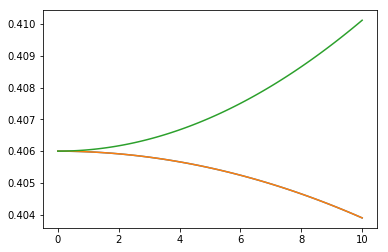

In [10]:
import matplotlib.pyplot as plt

stark = []
for fz in np.linspace(0, 10, 100): # field in kV
    #print("do fz =", fz, "kV/cm ...")
    Htot = H0 - H * dz * fz*1000 * conv_to_cm
    enr, vec = np.linalg.eigh(Htot)
    stark.append([fz, *enr])
stark = np.array(stark)

plt.plot(stark[:,0], stark[:,2])
plt.plot(stark[:,0], stark[:,3])
plt.plot(stark[:,0], stark[:,4])
